# Team 3: EMBED
## Target: Reducing Biopsy Burden

In [1]:
import torch
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from torchvision import transforms, utils
import glob
import random 
import SimpleITK as sitk
import torch.nn.functional as F

In [2]:
## Check if CUDA is installed and check memory
torch.cuda.empty_cache()
print(torch.cuda.is_available())
print(torch.cuda.memory_reserved())
print(torch.cuda.memory_allocated(device=None))
torch.manual_seed(56)

True
0
0


In [3]:
class CXR_data(Dataset):

    def __init__(self, csv_file, transform0=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.            
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.info = pd.read_csv(csv_file)
        self.transform0 = transform0        
        
        self.targets = F.one_hot(torch.tensor(list(pd.read_csv(csv_file)['Label'])))
        
    def __len__(self):
        return len(self.info)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()            

        img_path0 = self.info['Path'][idx]        
        image0 = sitk.ReadImage(img_path0, sitk.sitkUInt8)        
        
        im_arr0 = sitk.GetArrayFromImage(image0)        
        im_tsr0 = torch.from_numpy(np.expand_dims(im_arr0/255.0, axis=0))
        lbls = self.targets[idx]     

        if self.transform0 :
            im_tsr0 = self.transform0(im_tsr0)     
                       
        else:
            im_tsr0 = im_tsr0            
            
        return im_tsr0.float(), lbls

In [4]:
train_transform0 = transforms.Compose([
    transforms.Resize((256,256))])

test_transform = transforms.Compose([
    transforms.Resize(size=(256,256))])

0 (1, 256, 256)
label:  tensor([1, 0])


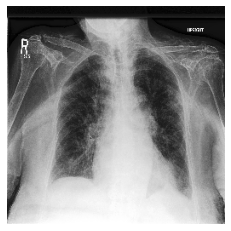

1 (1, 256, 256)
label:  tensor([0, 1])


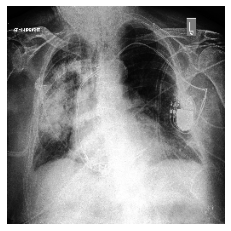

2 (1, 256, 256)
label:  tensor([0, 1])


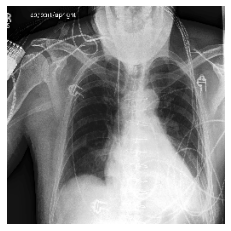

3 (1, 256, 256)
label:  tensor([1, 0])


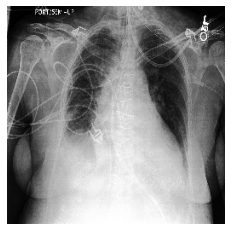

4 (1, 256, 256)
label:  tensor([1, 0])


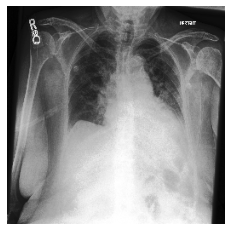

5 (1, 256, 256)
label:  tensor([1, 0])


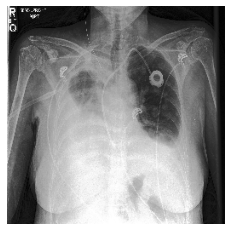

In [5]:
CXR_dataset = CXR_data(csv_file='./labels_prototyping.csv', transform0=train_transform0)

def show_images(image, labels):
    """Show image and label"""        
    plt.imshow(np.squeeze((image).numpy()), cmap='gray')
    plt.axis('off')
    print('label: ',labels)
    plt.pause(0.001) 

fig = plt.figure()

for i in range(len(CXR_dataset)):
    im0, lbl = CXR_dataset[i]

    print(i, (im0.numpy()).shape)
    show_images(im0, lbl)

    if i == 5:
        plt.show()
        break

In [6]:
import torch.nn as nn
from torchvision.models.resnet import resnet18
from torchvision.models import ResNet18_Weights
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [7]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=1, bias=False)
        
        self.model.fc = nn.Sequential(nn.Linear(512, 2), nn.Softmax(dim=1))
                
    def forward(self, x):
        x = self.model(x) 
        
        return x    

In [8]:
# train for one epoch to learn unique features
def train(net, data_loader, train_optimizer, device):
    net.train()
    total_loss, total_acc_cla, total_num, train_bar = 0.0, 0.0, 0, tqdm(data_loader)
   
    for pos_1, target in train_bar:
        pos_1, target = pos_1.to(device), target.to(device)
        #print(len(pos_1), len(target))
        cla1 = net(pos_1)
        #print(cla1.shape, target.shape)
        # Class loss
        Cla_loss = nn.CrossEntropyLoss()
        loss = Cla_loss(cla1, target.float())
        
        train_optimizer.zero_grad()
        loss.backward()
        train_optimizer.step()

        total_num += pos_1.size(0)
        total_loss += loss.item() * pos_1.size(0)
        
        # labels predicted by the classifier          
        pred_labels_cla1 = torch.argmax(cla1.round(), dim=1).unsqueeze(dim=-1)
        aa = torch.sum((pred_labels_cla1 == torch.argmax(target, dim=1).unsqueeze(dim=-1)).any(dim=-1).float()).item()    
        total_acc_cla += aa
        
        train_bar.set_description('Train Epoch: [{}/{}] Loss: {:.4f} ACC: {:.2f}%'.format(epoch, epochs, total_loss/total_num, total_acc_cla/total_num*100))
        
    return total_loss / total_num, total_acc_cla / total_num*100

In [9]:
def validate(net, data_loader):
    net.eval()
    with torch.no_grad():
        total_loss, total_acc_cla, total_num, val_bar = 0.0, 0.0, 0, tqdm(data_loader)
        y_pred = []
        y_true = []
        i = 0
        for pos_1, target in val_bar:
            pos_1, target = pos_1.to(device), target.to(device)            
            cla1 = net(pos_1)

            # Class loss
            Cla_loss = nn.CrossEntropyLoss()
            loss = Cla_loss(cla1, target.float())

            total_num += pos_1.size(0)
            total_loss += loss.item() * pos_1.size(0)
            
            # labels predicted by the classifier                       
            pred_labels_cla1 = torch.argmax(cla1.round(), dim=1).unsqueeze(dim=-1)
            target_temp = torch.argmax(target, dim=1).unsqueeze(dim=-1)
            aa = torch.sum((pred_labels_cla1 == target_temp).any(dim=-1).float()).item()    
            total_acc_cla += aa 
            
            #store the labels
            y_pred.append(pred_labels_cla1.cpu().detach().numpy().squeeze())
            y_true.append(target_temp.cpu().detach().numpy().squeeze())
            
            # calculate AUC for showing
            y_true_temp = np.concatenate(y_true)
            y_pred_temp = np.concatenate(y_pred)
           
            if i>=3:
                val_auc_temp = roc_auc_score(y_true_temp, y_pred_temp) 
                acc_test = np.sum((y_true_temp.round()==y_pred_temp.round()).astype(int))/y_true_temp.shape[0]
            else:
                acc_test = 0.0
                val_auc_temp = 0.0
            i += 1
            val_bar.set_description('Validation Epoch: [{}/{}] Loss: {:.4f} ACC: {:.2f}% AUC: {:.2f} ACC2: {:.2f}%'.format(epoch, epochs, total_loss/total_num, total_acc_cla/total_num*100, val_auc_temp, acc_test*100))
        
        # calculate AUC
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        val_auc_mean =  roc_auc_score(y_true, y_pred) 
        
    return total_loss / total_num, total_acc_cla/total_num*100, val_auc_mean

In [10]:
# Parameters
batch_size = 32 #Number of images in each mini-batch
epochs = 30 #Number of sweeps over the dataset to train
kfold = 5 # for cross-validation
lr = 2.5e-4

In [11]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

splits = KFold(n_splits=kfold, shuffle=True, random_state=56)

dataset = CXR_data(csv_file='./labels_prototyping.csv', transform0=train_transform0)

for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))
    
    # Shuffle indexes
    np.random.shuffle(train_idx)
    
    # data prepare
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, drop_last=True)    
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, drop_last=True)     
    
    # model setup and optimizer config

    #model = nn.DataParallel(Model())
    model = Model()
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)     
    scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)

    # training loop
    results = { 'val_loss': [], 'val_acc':[], 'val_auc':[], 'lr':[]}
    
    if not os.path.exists('results'):
        os.mkdir('results')
        
    best_acc = 0.0
    best_loss = 999.0
    for epoch in range(1, epochs + 1):
        _, _ = train(model, train_loader, optimizer, device)
        #train_loss, train_acc, train_auc = train_eval(model, eval_loader)
        #results['train_loss'].append(train_loss)
        #results['train_acc'].append(train_acc)
        #results['train_auc'].append(train_auc)
        val_loss, val_acc, val_auc = validate(model, val_loader)
        results['val_loss'].append(val_loss)
        results['val_acc'].append(val_acc)
        results['val_auc'].append(val_auc)
        #knn_acc = eval_sim(model, memory_loader, test_loader)
        #results['knn_acc'].append(knn_acc)
        results['lr'].append(get_lr(optimizer))
        
        scheduler1.step(val_loss)
        
        # save statistics
        data_frame = pd.DataFrame(data=results, index=range(1, epoch + 1))
        data_frame.to_csv('results/{}epochs_fold{}-{}_statistics.csv'.format(epochs, kfold, fold+1), index_label='epoch')
        
        if (val_acc >= best_acc) and (val_loss <= best_loss):
            best_acc = val_acc
            best_loss = val_loss
            torch.save(model.state_dict(), 'results/epoch{}-{}_fold{}-{}_model.pth'.format(epochs, epoch, kfold, fold+1))
            
       
    # save the last model
    torch.save(model.state_dict(), 'results/epoch{}-{}_fold{}-{}_model.pth'.format(epochs, epoch, kfold, fold+1))
    

Fold 1


Train Epoch: [1/30] Loss: 0.5151 ACC: 77.73%: 100%|██████████| 40/40 [01:25<00:00,  2.14s/it]
Validation Epoch: [1/30] Loss: 0.7735 ACC: 49.06% AUC: 0.54 ACC2: 49.06%: 100%|██████████| 10/10 [00:20<00:00,  2.06s/it]
Train Epoch: [2/30] Loss: 0.4154 ACC: 89.22%: 100%|██████████| 40/40 [01:21<00:00,  2.03s/it]
Validation Epoch: [2/30] Loss: 0.4646 ACC: 83.44% AUC: 0.82 ACC2: 83.44%: 100%|██████████| 10/10 [00:20<00:00,  2.02s/it]
Train Epoch: [3/30] Loss: 0.3786 ACC: 93.67%: 100%|██████████| 40/40 [01:21<00:00,  2.03s/it]
Validation Epoch: [3/30] Loss: 0.4456 ACC: 85.94% AUC: 0.85 ACC2: 85.94%: 100%|██████████| 10/10 [00:20<00:00,  2.02s/it]
Train Epoch: [4/30] Loss: 0.3644 ACC: 95.00%: 100%|██████████| 40/40 [01:21<00:00,  2.04s/it]
Validation Epoch: [4/30] Loss: 0.4845 ACC: 80.94% AUC: 0.79 ACC2: 80.94%: 100%|██████████| 10/10 [00:20<00:00,  2.03s/it]
Train Epoch: [5/30] Loss: 0.3430 ACC: 96.88%: 100%|██████████| 40/40 [01:22<00:00,  2.06s/it]
Validation Epoch: [5/30] Loss: 0.4226 ACC:

Fold 2


Train Epoch: [1/30] Loss: 0.5319 ACC: 75.78%: 100%|██████████| 40/40 [01:19<00:00,  1.99s/it]
Validation Epoch: [1/30] Loss: 0.7486 ACC: 55.00% AUC: 0.61 ACC2: 55.00%: 100%|██████████| 10/10 [00:18<00:00,  1.89s/it]
Train Epoch: [2/30] Loss: 0.4171 ACC: 88.83%: 100%|██████████| 40/40 [01:19<00:00,  1.99s/it]
Validation Epoch: [2/30] Loss: 0.4674 ACC: 84.38% AUC: 0.85 ACC2: 84.38%: 100%|██████████| 10/10 [00:18<00:00,  1.90s/it]
Train Epoch: [3/30] Loss: 0.3686 ACC: 94.53%: 100%|██████████| 40/40 [01:19<00:00,  1.99s/it]
Validation Epoch: [3/30] Loss: 0.5887 ACC: 71.25% AUC: 0.67 ACC2: 71.25%: 100%|██████████| 10/10 [00:18<00:00,  1.89s/it]
Train Epoch: [4/30] Loss: 0.3758 ACC: 93.52%: 100%|██████████| 40/40 [01:20<00:00,  2.00s/it]
Validation Epoch: [4/30] Loss: 0.4446 ACC: 86.25% AUC: 0.85 ACC2: 86.25%: 100%|██████████| 10/10 [00:19<00:00,  1.90s/it]
Train Epoch: [5/30] Loss: 0.3512 ACC: 96.17%: 100%|██████████| 40/40 [01:21<00:00,  2.03s/it]
Validation Epoch: [5/30] Loss: 0.4036 ACC:

Fold 3


Train Epoch: [1/30] Loss: 0.5154 ACC: 78.52%: 100%|██████████| 40/40 [01:21<00:00,  2.03s/it]
Validation Epoch: [1/30] Loss: 0.7852 ACC: 48.12% AUC: 0.57 ACC2: 48.12%: 100%|██████████| 10/10 [00:20<00:00,  2.07s/it]
Train Epoch: [2/30] Loss: 0.4128 ACC: 89.69%: 100%|██████████| 40/40 [01:18<00:00,  1.97s/it]
Validation Epoch: [2/30] Loss: 0.4473 ACC: 85.62% AUC: 0.86 ACC2: 85.62%: 100%|██████████| 10/10 [00:19<00:00,  1.94s/it]
Train Epoch: [3/30] Loss: 0.3698 ACC: 94.53%: 100%|██████████| 40/40 [01:21<00:00,  2.03s/it]
Validation Epoch: [3/30] Loss: 0.4790 ACC: 81.56% AUC: 0.84 ACC2: 81.56%: 100%|██████████| 10/10 [00:19<00:00,  1.91s/it]
Train Epoch: [4/30] Loss: 0.3645 ACC: 94.92%: 100%|██████████| 40/40 [01:23<00:00,  2.10s/it]
Validation Epoch: [4/30] Loss: 0.4446 ACC: 86.56% AUC: 0.88 ACC2: 86.56%: 100%|██████████| 10/10 [00:19<00:00,  1.91s/it]
Train Epoch: [5/30] Loss: 0.3565 ACC: 95.23%: 100%|██████████| 40/40 [01:23<00:00,  2.09s/it]
Validation Epoch: [5/30] Loss: 0.4318 ACC:

Fold 4


Train Epoch: [1/30] Loss: 0.5280 ACC: 76.48%: 100%|██████████| 40/40 [01:18<00:00,  1.97s/it]
Validation Epoch: [1/30] Loss: 0.8417 ACC: 45.00% AUC: 0.51 ACC2: 45.00%: 100%|██████████| 10/10 [00:20<00:00,  2.00s/it]
Train Epoch: [2/30] Loss: 0.4074 ACC: 90.55%: 100%|██████████| 40/40 [01:18<00:00,  1.97s/it]
Validation Epoch: [2/30] Loss: 0.4439 ACC: 85.00% AUC: 0.85 ACC2: 85.00%: 100%|██████████| 10/10 [00:20<00:00,  2.00s/it]
Train Epoch: [3/30] Loss: 0.3905 ACC: 92.03%: 100%|██████████| 40/40 [01:18<00:00,  1.97s/it]
Validation Epoch: [3/30] Loss: 0.4827 ACC: 82.50% AUC: 0.80 ACC2: 82.50%: 100%|██████████| 10/10 [00:20<00:00,  2.00s/it]
Train Epoch: [4/30] Loss: 0.3629 ACC: 94.92%: 100%|██████████| 40/40 [01:19<00:00,  1.98s/it]
Validation Epoch: [4/30] Loss: 0.4994 ACC: 80.62% AUC: 0.83 ACC2: 80.62%: 100%|██████████| 10/10 [00:19<00:00,  1.99s/it]
Train Epoch: [5/30] Loss: 0.3493 ACC: 96.33%: 100%|██████████| 40/40 [01:18<00:00,  1.97s/it]
Validation Epoch: [5/30] Loss: 0.4967 ACC:

Fold 5


Train Epoch: [1/30] Loss: 0.5416 ACC: 76.02%: 100%|██████████| 40/40 [01:19<00:00,  1.98s/it]
Validation Epoch: [1/30] Loss: 0.5143 ACC: 79.38% AUC: 0.78 ACC2: 79.38%: 100%|██████████| 10/10 [00:19<00:00,  1.99s/it]
Train Epoch: [2/30] Loss: 0.4191 ACC: 89.30%: 100%|██████████| 40/40 [01:19<00:00,  1.98s/it]
Validation Epoch: [2/30] Loss: 0.4767 ACC: 82.19% AUC: 0.81 ACC2: 82.19%: 100%|██████████| 10/10 [00:20<00:00,  2.01s/it]
Train Epoch: [3/30] Loss: 0.3811 ACC: 92.89%: 100%|██████████| 40/40 [01:19<00:00,  1.98s/it]
Validation Epoch: [3/30] Loss: 0.4819 ACC: 81.25% AUC: 0.82 ACC2: 81.25%: 100%|██████████| 10/10 [00:19<00:00,  2.00s/it]
Train Epoch: [4/30] Loss: 0.3776 ACC: 93.59%: 100%|██████████| 40/40 [01:19<00:00,  1.98s/it]
Validation Epoch: [4/30] Loss: 0.4832 ACC: 80.94% AUC: 0.82 ACC2: 80.94%: 100%|██████████| 10/10 [00:19<00:00,  1.99s/it]
Train Epoch: [5/30] Loss: 0.3570 ACC: 95.55%: 100%|██████████| 40/40 [01:21<00:00,  2.03s/it]
Validation Epoch: [5/30] Loss: 0.4270 ACC:

In [13]:
# Parameters
batch_size = 32 #Number of images in each mini-batch
epochs = 20 #Number of sweeps over the dataset to train
lr = 2.5e-4

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


dataset = CXR_data(csv_file='./labels_prototyping.csv', transform0=train_transform0)

train_loader = DataLoader(dataset, batch_size=batch_size, drop_last=True)    
val_loader = DataLoader(dataset, batch_size=batch_size, drop_last=True)     

# model setup and optimizer config

#model = nn.DataParallel(Model())
model = Model()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)     
scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)

# training loop
results = { 'val_loss': [], 'val_acc':[], 'val_auc':[], 'lr':[]}

if not os.path.exists('results'):
    os.mkdir('results')

best_acc = 0.0
best_loss = 999.0
for epoch in range(1, epochs + 1):
    _, _ = train(model, train_loader, optimizer, device)
    #train_loss, train_acc, train_auc = train_eval(model, eval_loader)
    #results['train_loss'].append(train_loss)
    #results['train_acc'].append(train_acc)
    #results['train_auc'].append(train_auc)
    val_loss, val_acc, val_auc = validate(model, val_loader)
    results['val_loss'].append(val_loss)
    results['val_acc'].append(val_acc)
    results['val_auc'].append(val_auc)
    #knn_acc = eval_sim(model, memory_loader, test_loader)
    #results['knn_acc'].append(knn_acc)
    results['lr'].append(get_lr(optimizer))

    scheduler1.step(val_loss)

    # save statistics
    data_frame = pd.DataFrame(data=results, index=range(1, epoch + 1))
    data_frame.to_csv('results/{}epochs_fold{}-{}_statistics.csv'.format(epochs, kfold, fold+1), index_label='epoch')

    if (val_acc >= best_acc) and (val_loss <= best_loss):
        best_acc = val_acc
        best_loss = val_loss
        torch.save(model.state_dict(), 'results/epoch{}-{}_fold{}-{}_model.pth'.format(epochs, epoch, kfold, fold+1))


# save the last model
torch.save(model.state_dict(), 'results/epoch{}-{}_fold{}-{}_model.pth'.format(epochs, epoch, kfold, fold+1))
    

Train Epoch: [1/20] Loss: 0.5126 ACC: 78.06%: 100%|██████████| 50/50 [01:43<00:00,  2.07s/it]
Validation Epoch: [1/20] Loss: 0.6047 ACC: 68.88% AUC: 0.72 ACC2: 68.88%: 100%|██████████| 50/50 [01:40<00:00,  2.02s/it]
Train Epoch: [2/20] Loss: 0.4092 ACC: 90.12%: 100%|██████████| 50/50 [01:38<00:00,  1.98s/it]
Validation Epoch: [2/20] Loss: 0.4330 ACC: 86.88% AUC: 0.85 ACC2: 86.88%: 100%|██████████| 50/50 [01:37<00:00,  1.95s/it]
Train Epoch: [3/20] Loss: 0.3763 ACC: 93.88%: 100%|██████████| 50/50 [01:38<00:00,  1.97s/it]
Validation Epoch: [3/20] Loss: 0.4241 ACC: 88.44% AUC: 0.90 ACC2: 88.44%: 100%|██████████| 50/50 [01:36<00:00,  1.93s/it]
Train Epoch: [4/20] Loss: 0.3553 ACC: 95.62%: 100%|██████████| 50/50 [01:38<00:00,  1.97s/it]
Validation Epoch: [4/20] Loss: 0.3471 ACC: 96.50% AUC: 0.96 ACC2: 96.50%: 100%|██████████| 50/50 [01:37<00:00,  1.96s/it]
Train Epoch: [5/20] Loss: 0.3524 ACC: 95.88%: 100%|██████████| 50/50 [01:38<00:00,  1.98s/it]
Validation Epoch: [5/20] Loss: 0.3449 ACC:

In [17]:
test_data =  CXR_data(csv_file='./labels_test.csv', transform0=train_transform0)
test_loader = DataLoader(test_data, batch_size=2, drop_last=True)     

In [18]:
validate(model, test_loader)

Validation Epoch: [20/20] Loss: 0.3974 ACC: 91.09% AUC: 0.91 ACC2: 91.09%: 100%|██████████| 16159/16159 [44:28<00:00,  6.05it/s]


(0.3974115148217115, 91.08855746023887, 0.9085043498128427)

In [13]:
from torchsummary import summary

model = Model().cuda()   
summary(model, (1, 256, 256))